# Training

## Mount Google Drive

In [ ]:
import keras
print(keras.__version__)
import tensorflow as tf
print(tf.__version__)
!pip list -v
!python --version

In [ ]:
from google.colab import drive
drive.mount('/content/gDrive')

Mounted at /content/gDrive


## Test if GPU is available

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

!nvidia-smi

## Begin training

In [1]:
# %load_ext tensorboard
import os
import csv
import joblib
import datetime
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

current_path = './facial/datasets/processed'
csv_path = current_path + '/dataset.csv'

target_names = ['angry', 'fear', 'happy', 'sad', 'surprise', 'neutral']
tick_marks = np.array(range(len(target_names))) + 0.5

In [2]:
def get_dataset(dataset_path):
    images = []
    labels = []
    pixels = []
    with open(dataset_path) as f:
        csvr = csv.reader(f)
        header = next(csvr)
        for i, (label, pixel) in enumerate(csvr):
            img = np.asarray([float(p) for p in pixel.split()])
            images.append(img)
            labels.append(label)

    print(dataset_path+" --> Length of data: "+str(len(labels)))
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

In [3]:
from sklearn.decomposition import PCA

# Load data
images, labels = get_dataset(csv_path)

# Split original dataset to train & test (80%-20%)
train_img, test_img, train_label, test_label = train_test_split(images, labels,
  train_size=0.8, shuffle=True, random_state=42)

./facial/datasets/processed/dataset.csv --> Length of data: 2999


In [4]:
# Models chosen in this project
import warnings
from sklearn import metrics
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

warnings.filterwarnings("ignore")
models = []
models.append(('DUMMY', DummyClassifier(strategy='prior')))
models.append(('SVM', SVC()))
models.append(('KNN', KNeighborsClassifier()))

In [ ]:
from sklearn.model_selection import GridSearchCV

# Grid search cross-validation for choosing best parameters
param_grid_knn = {'n_neighbors':[3,4,5,6,7]}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn)
grid_knn.fit(train_img,train_label)
print("KNN: ",grid_knn.best_params_)

param_grid_svm = {'gamma':[0.0001,0.001,0.01], 'C':[0.01,1,10]}
grid_svm = GridSearchCV(SVC(), param_grid_svm, n_jobs=-1)
grid_svm.fit(train_img,train_label)
print("SVM: ",grid_svm.best_params_)

In [6]:
def classifer_model(model, model_name, save_model=False, plot_cr=False, plot_cm=False):
  # Train model
  print("Training...")
  model.fit(train_img, train_label)

  # Model result
  acc = model.score(test_img, test_label)
  print(' Acc: ', acc)
  print('=== Model training completed. ===')

  if save_model:
    out_name = './' + model_name + '.model'
    joblib.dump(model, out_name)
    print('=== Model has been saved. ===')

  # Plot classification report
  y_pred = model.predict(test_img)
  y_true = test_label

  if plot_cr:
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names=target_names))

  if plot_cm:
    # Plot confusion matrix
    # %matplotlib inline
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    np.set_printoptions(precision=3)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm_normalized)
    plt.figure(figsize=(12, 8), dpi=120)

    ind_array = np.arange(len(target_names))
    x, y = np.meshgrid(ind_array, ind_array)

    for x_val, y_val in zip(x.flatten(), y.flatten()):
      c = cm_normalized[y_val][x_val]
      plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=10, va='center', ha='center')
    # offset the tick
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.grid(True, which='minor', linestyle='-')
    plt.gcf().subplots_adjust(bottom=0.15)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title('Normalized confusion matrix')
    plt.colorbar()
    xlocations = np.array(range(len(target_names)))
    plt.xticks(xlocations, target_names)
    plt.yticks(xlocations, target_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Training...
 Acc:  0.14666666666666667
=== Model training completed. ===
=== Model has been saved. ===
Classification Report:
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00        96
        fear       0.00      0.00      0.00       119
       happy       0.00      0.00      0.00       100
         sad       0.15      1.00      0.26        88
    surprise       0.00      0.00      0.00       100
     neutral       0.00      0.00      0.00        97

    accuracy                           0.15       600
   macro avg       0.02      0.17      0.04       600
weighted avg       0.02      0.15      0.04       600

[[  0   0   0  96   0   0]
 [  0   0   0 119   0   0]
 [  0   0   0 100   0   0]
 [  0   0   0  88   0   0]
 [  0   0   0 100   0   0]
 [  0   0   0  97   0   0]]
[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


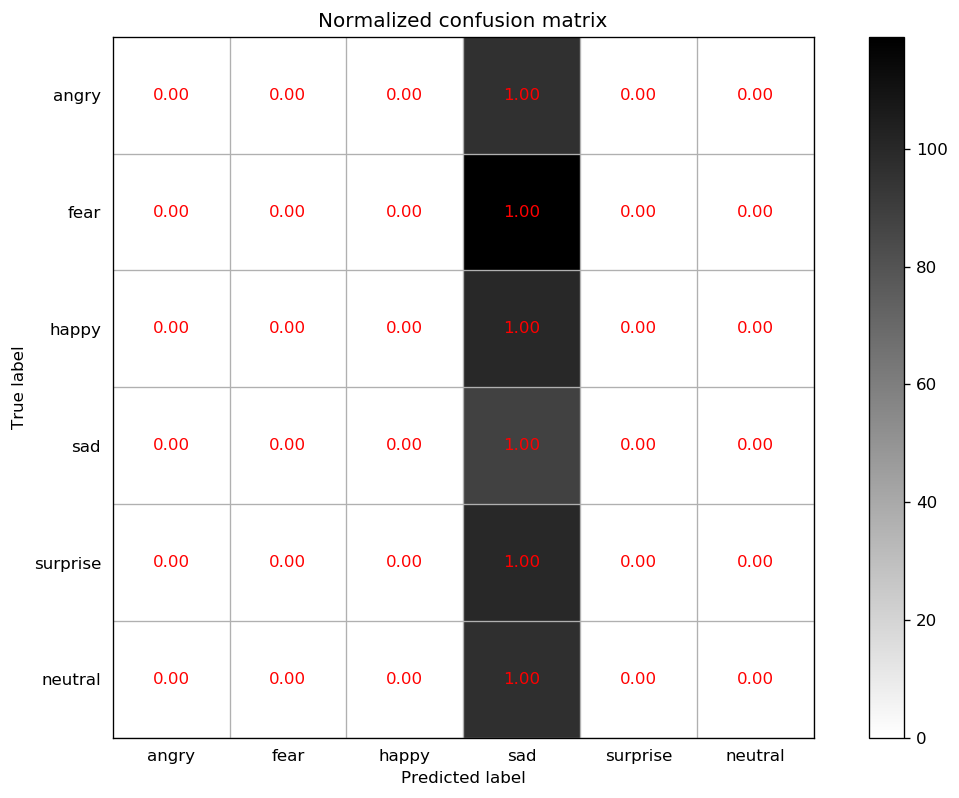

In [7]:
classifer_model(DummyClassifier(strategy='prior'), 'dummy', False, True, True)

Training...
 Acc:  0.495
=== Model training completed. ===
=== Model has been saved. ===
Classification Report:
              precision    recall  f1-score   support

       angry       0.38      0.39      0.38        96
        fear       0.43      0.34      0.38       119
       happy       0.57      0.62      0.59       100
         sad       0.42      0.47      0.44        88
    surprise       0.74      0.74      0.74       100
     neutral       0.42      0.43      0.43        97

    accuracy                           0.49       600
   macro avg       0.49      0.50      0.49       600
weighted avg       0.49      0.49      0.49       600

[[37 26  6  6  1 20]
 [27 41 10  9  5 27]
 [ 6  4 62 14 10  4]
 [ 7  9 17 41  8  6]
 [ 1  1 11 12 74  1]
 [19 15  3 16  2 42]]
[[0.385 0.271 0.062 0.062 0.01  0.208]
 [0.227 0.345 0.084 0.076 0.042 0.227]
 [0.06  0.04  0.62  0.14  0.1   0.04 ]
 [0.08  0.102 0.193 0.466 0.091 0.068]
 [0.01  0.01  0.11  0.12  0.74  0.01 ]
 [0.196 0.155 0.031 0.1

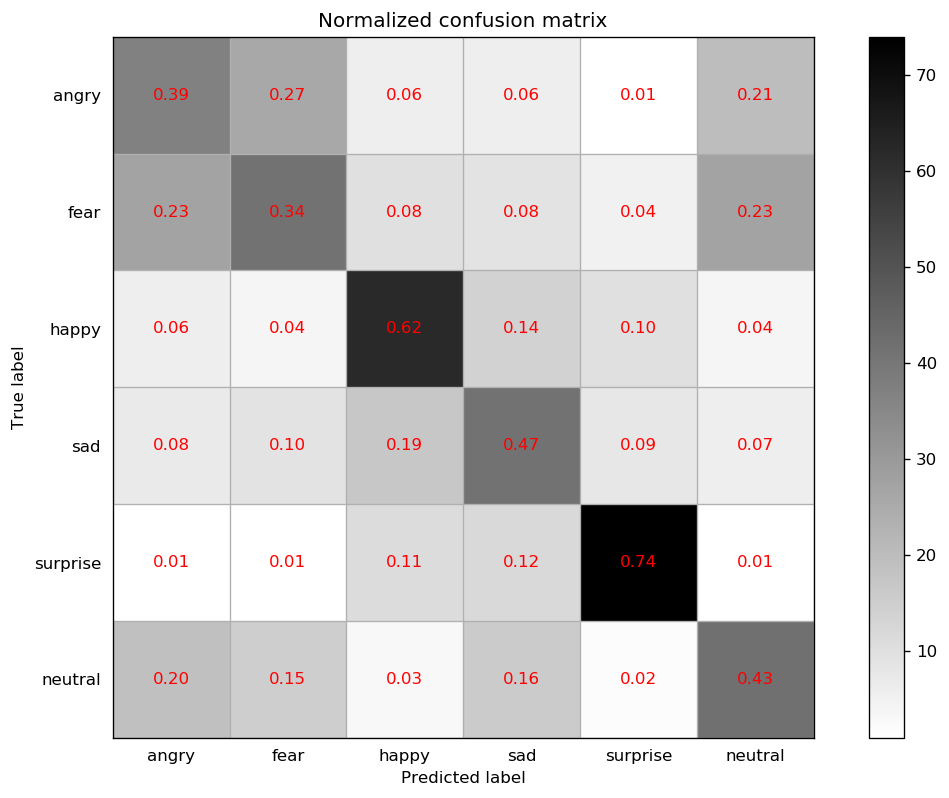

In [8]:
classifer_model(SVC(), 'svc', True, True, True)

Training...
 Acc:  0.37
=== Model training completed. ===
=== Model has been saved. ===
Classification Report:
              precision    recall  f1-score   support

       angry       0.30      0.36      0.33        96
        fear       0.34      0.25      0.29       119
       happy       0.51      0.32      0.39       100
         sad       0.27      0.30      0.28        88
    surprise       0.61      0.67      0.64       100
     neutral       0.25      0.33      0.29        97

    accuracy                           0.37       600
   macro avg       0.38      0.37      0.37       600
weighted avg       0.38      0.37      0.37       600

[[35 15  3 16  2 25]
 [37 30  5 10  8 29]
 [ 7  6 32 20 17 18]
 [13 11 11 26 12 15]
 [ 3  2  7 13 67  8]
 [21 24  5 11  4 32]]
[[0.365 0.156 0.031 0.167 0.021 0.26 ]
 [0.311 0.252 0.042 0.084 0.067 0.244]
 [0.07  0.06  0.32  0.2   0.17  0.18 ]
 [0.148 0.125 0.125 0.295 0.136 0.17 ]
 [0.03  0.02  0.07  0.13  0.67  0.08 ]
 [0.216 0.247 0.052 0.11

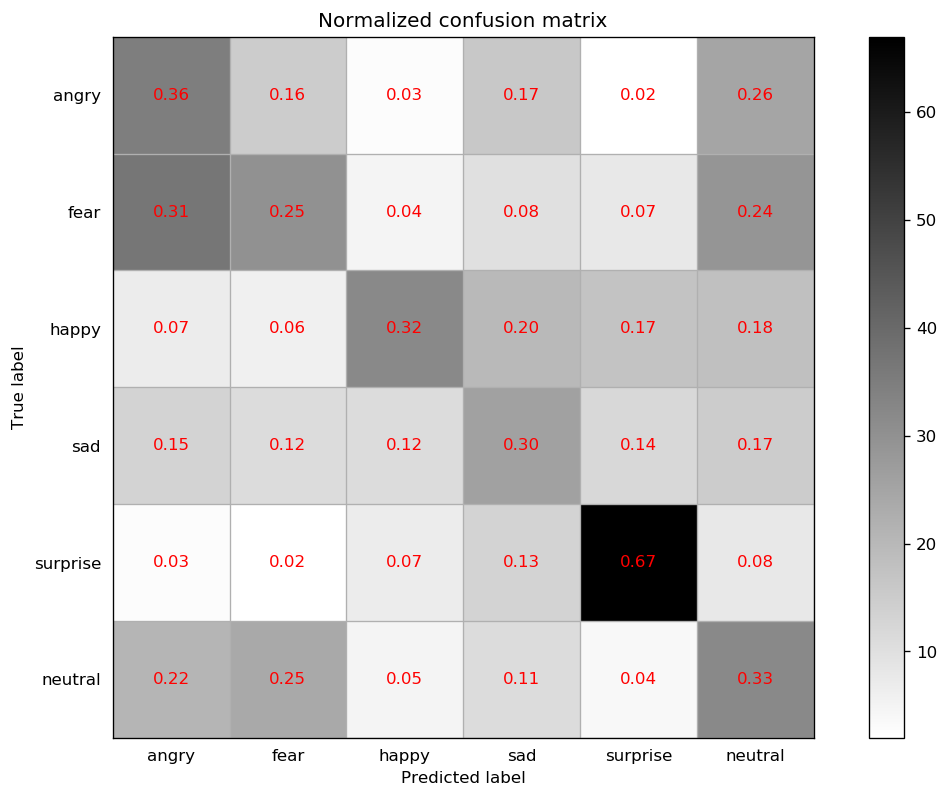

In [9]:
classifer_model(KNeighborsClassifier(n_neighbors=6), 'knn', True, True, True)